In [14]:
import os
import NNpy
import h5py
import json
import time
import pyccl
import scipy
import numpy
from itertools import product
from matplotlib import pyplot
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.lines as mlines

In [2]:
'''
#Data path

TYPE = 'NN'
PATH = '/pscratch/sd/y/yhzhang/TensorCloud/'

DATA_PATH = PATH + 'DATA/'
PLOT_PATH = PATH + 'PLOT/' + TYPE + '/'
'''
# Path
folder = '/global/cfs/cdirs/lsst/groups/MCP/CosmoCloud/SOMZCloud/'
cell_folder = os.path.join(folder, 'CELL/')
info_folder = os.path.join(folder, 'INFO/')
model_folder = os.path.join(folder, 'MODEL/')
tag='Y1'
typ='FIDUCIAL'
label='DOUBLE'
name='NN'

In [3]:
'''
#Load in Data

BIN_SIZE = 4
GRID_SIZE = 128
DATA_SIZE = 100000

with h5py.File(DATA_PATH + 'DATA.hdf5','r') as DATA:
    
    REDSHIFT_GRID = numpy.array(DATA['realizations/z'][:GRID_SIZE], dtype = 'float32')
    DATA_GRID = numpy.array(DATA['realizations/pdfs'][:DATA_SIZE, :BIN_SIZE, :GRID_SIZE], dtype = 'float32')
'''
# Load
with h5py.File('/global/cfs/cdirs/lsst/groups/MCP/CosmoCloud/SOMZCloud/CALIBRATE/{}/CORRECT/TITANIUM/HYBRID.hdf5'.format(tag), 'r') as file:
    data_lens = file['lens']['data'][...]
data_size, bin_lens_size, z_size = data_lens.shape

# Galaxy
with open(os.path.join(info_folder, 'GALAXY.json'), 'r') as file:
    galaxy_info = json.load(file)
# Redshift
z1 = 0.0
z2 = 3.0
z_grid = numpy.linspace(z1, z2, z_size)

In [4]:
'''
# COSMOLOGY

with open(DATA_PATH + 'COSMO.json', 'r') as cosmo:
    
    COSMO = json.load(cosmo)

COSMO_CCL = pyccl.Cosmology(
    h = COSMO['H'],
    w0 = COSMO['W0'],
    wa = COSMO['WA'], 
    n_s = COSMO['NS'], 
    A_s = COSMO['AS'],
    m_nu = COSMO['MNU'],  
    Neff = COSMO['NEFF'],
    T_CMB = COSMO['TCMB'], 
    Omega_k = COSMO['OMEGAK'], 
    Omega_c = COSMO['OMEGAC'], 
    Omega_b = COSMO['OMEGAB'], 
    matter_power_spectrum = 'halofit',  
    transfer_function = 'boltzmann_camb', 
    extra_parameters = {'camb': {'kmax': 2000, 'lmax': 2000, 'halofit_version': 'mead2020_feedback', 'HMCode_logT_AGN': 7.8}}
)
'''
# Cosmology
with open(os.path.join(info_folder, 'COSMOLOGY.json'), 'r') as file:
    cosmology_info = json.load(file)

Omega_m = cosmology_info['OMEGA_M']

cosmology = pyccl.Cosmology(
    h=cosmology_info['H'],
    w0=cosmology_info['W0'],
    wa=cosmology_info['WA'],
    n_s=cosmology_info['NS'], 
    A_s=cosmology_info['AS'], 
    m_nu=cosmology_info['M_NU'],
    Neff=cosmology_info['N_EFF'],
    Omega_k=cosmology_info['OMEGA_K'], 
    Omega_b=cosmology_info['OMEGA_B'], 
    Omega_c=cosmology_info['OMEGA_CDM'],
    Omega_g=cosmology_info['OMEGA_GAMMA'], 
    mass_split = 'single', matter_power_spectrum = 'halofit', transfer_function = 'boltzmann_camb',
    extra_parameters = {'camb': {'kmax': 100, 'lmax': 5000, 'halofit_version': 'mead2020_feedback', 'HMCode_logT_AGN': 7.8}}
)

    
pyccl.spline_params.N_K = z_size
pyccl.gsl_params.NZ_NORM_SPLINE_INTEGRATION = True

In [5]:
'''
#Restrcture the data

PSI_GRID = numpy.mean(DATA_GRID, axis = 0)
SIGMA_GRID = numpy.std(DATA_GRID, axis = 0)
A_GRID = numpy.array(1 / (1 + REDSHIFT_GRID), dtype = 'float32')

CHI_GRID = COSMO_CCL.comoving_radial_distance(a = A_GRID)
PHI_GRID = PSI_GRID * COSMO_CCL.h_over_h0(a = 1 / (1 + REDSHIFT_GRID)) * COSMO['H'] * 100000 / scipy.constants.c

ELL_SIZE = 200
ELL_DATA = numpy.logspace(2, 4, ELL_SIZE + 1)
CHI_MESH, ELL_MESH = numpy.meshgrid(CHI_GRID, ELL_DATA)
SCALE_GRID = numpy.nan_to_num(numpy.divide(ELL_MESH + 1/2, CHI_MESH, out = numpy.zeros((ELL_SIZE + 1, GRID_SIZE)) + numpy.inf, where = CHI_MESH > 0))

POWER_GRID = numpy.zeros((ELL_SIZE + 1, GRID_SIZE))
for GRID_INDEX in range(GRID_SIZE):

    POWER_GRID[:,GRID_INDEX] = COSMO_CCL.linear_matter_power(k = SCALE_GRID[:,GRID_INDEX], a = A_GRID[GRID_INDEX])
'''
# Multipole
ell1 = 20
ell2 = 2000
ell_size = 20
ell_grid = numpy.geomspace(ell1, ell2, ell_size + 1)
ell_data = numpy.sqrt(ell_grid[+1:] * ell_grid[:-1])

LENS_PSI_GRID = numpy.mean(data_lens, axis = 0)
LENS_SIGMA_GRID = numpy.std(data_lens, axis = 0)
A_GRID = numpy.array(1 / (1 + z_grid), dtype = 'double')

CHI_GRID = cosmology.comoving_radial_distance(a = A_GRID)
LENS_PHI_GRID = LENS_PSI_GRID * cosmology.h_over_h0(a = 1 / (1 + z_grid)) * cosmology_info['H'] * 100000 / scipy.constants.c

CHI_MESH, ELL_MESH = numpy.meshgrid(CHI_GRID, ell_grid)
SCALE_GRID = numpy.nan_to_num(numpy.divide(ELL_MESH + 1/2, CHI_MESH, out = numpy.zeros((ell_size + 1, z_size)) + numpy.inf, where = CHI_MESH > 0))
POWER_GRID = numpy.zeros((ell_size + 1, z_size))
for GRID_INDEX in range(z_size):

    POWER_GRID[:,GRID_INDEX] = cosmology.nonlin_matter_power(k = SCALE_GRID[:,GRID_INDEX], a = A_GRID[GRID_INDEX])
AMPLITUDE = 1

In [6]:
#Define angular power spectrum

def c_m1_m2(amplitude, phi_m1_grid, phi_m2_grid, chi_grid, power_grid, redshift_grid, type):

    pgg = scipy.interpolate.interp1d(chi_grid, power_grid, kind = type)
    
    phi_m1 = scipy.interpolate.interp1d(chi_grid, phi_m1_grid, kind = type)
    
    phi_m2 = scipy.interpolate.interp1d(chi_grid, phi_m2_grid, kind = type)
    
    function = lambda chi: phi_m1(chi) * phi_m2(chi) * pgg(chi) / (chi**2)
    
    c_m1_m2_ell = amplitude * scipy.integrate.fixed_quad(func = function, a = chi_grid.min(), b = chi_grid.max(), n = 500)[0]

    return c_m1_m2_ell

In [7]:
#Compare different numeric equations
AMPLITUDE = 1 #3 / 2 * (COSMO['OMEGAM'] + COSMO['OMEGAN']) * (COSMO['H'] * 100000 / scipy.constants.c)**2 * numpy.sqrt((1 + 3 / (2 * ELL_DATA + 1)) * (1 + 1 / (2 * ELL_DATA + 1)) * (1 - 1 / (2 * ELL_DATA + 1)) * (1 - 3 / (2 * ELL_DATA + 1)))
C_DATA = numpy.zeros((bin_lens_size, bin_lens_size, ell_size+1))
C_DATA1 = numpy.zeros((bin_lens_size, bin_lens_size, ell_size+1))
C_DATA2 = numpy.zeros((bin_lens_size, bin_lens_size, ell_size+1))
C_DATA3 = numpy.zeros((bin_lens_size, bin_lens_size, ell_size+1))
C_CCL = numpy.zeros((bin_lens_size, bin_lens_size, ell_size+1))

T0 = time.time()
C_DATA = NNpy.function(amplitude = AMPLITUDE, phi_grid1 = LENS_PHI_GRID, phi_grid2 = LENS_PHI_GRID, chi_grid = CHI_GRID, power_grid = POWER_GRID, redshift_grid = z_grid)

T1 = time.time()
T_TC=T1 - T0
T_pyccl=0

for (BIN_INDEX1, BIN_INDEX2) in product(range(bin_lens_size), range(bin_lens_size)):
    
    T0 = time.time()
    
    TRACER1 = pyccl.tracers.NumberCountsTracer(cosmo = cosmology, dndz = [z_grid, LENS_PSI_GRID[BIN_INDEX1,:]], bias = [z_grid, numpy.ones(z_size)], mag_bias=None, has_rsd=False, n_samples = z_size)
    TRACER2 = pyccl.tracers.NumberCountsTracer(cosmo = cosmology, dndz = [z_grid, LENS_PSI_GRID[BIN_INDEX2,:]], bias = [z_grid, numpy.ones(z_size)], mag_bias=None, has_rsd=False, n_samples = z_size)
    
    pyccl.gsl_params.NZ_NORM_SPLINE_INTEGRATION = False
    pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False
    C_CCL[BIN_INDEX1, BIN_INDEX2,:] = pyccl.cells.angular_cl(cosmo = cosmology, tracer1 = TRACER1, tracer2 = TRACER2, ell=ell_grid, p_of_k_a='delta_matter:delta_matter', l_limber=-1, limber_max_error=0.01, limber_integration_method='qag_quad', non_limber_integration_method='FKEM', fkem_chi_min=0, fkem_Nchi=z_size, p_of_k_a_lin='delta_matter:delta_matter', return_meta=False)
    T1 = time.time()
    T_pyccl=T_pyccl+T1-T0
    for ELL_INDEX in range(ell_size + 1):
        
        C_DATA1[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_m1_m2(amplitude = AMPLITUDE, phi_m1_grid = LENS_PHI_GRID[BIN_INDEX1,:], phi_m2_grid = LENS_PHI_GRID[BIN_INDEX2,:], chi_grid = CHI_GRID, power_grid = POWER_GRID[ELL_INDEX,:], redshift_grid = z_grid, type = 'slinear')
        C_DATA2[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_m1_m2(amplitude = AMPLITUDE, phi_m1_grid = LENS_PHI_GRID[BIN_INDEX1,:], phi_m2_grid = LENS_PHI_GRID[BIN_INDEX2,:], chi_grid = CHI_GRID, power_grid = POWER_GRID[ELL_INDEX,:], redshift_grid = z_grid, type = 'quadratic')
        C_DATA3[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_m1_m2(amplitude = AMPLITUDE, phi_m1_grid = LENS_PHI_GRID[BIN_INDEX1,:], phi_m2_grid = LENS_PHI_GRID[BIN_INDEX2,:], chi_grid = CHI_GRID, power_grid = POWER_GRID[ELL_INDEX,:], redshift_grid = z_grid, type = 'cubic')   
        
    T2 = time.time()
    print(BIN_INDEX1, BIN_INDEX2, T1 - T0, T2 - T1)
print('TensorCloud calculation time for NN:%fs' %T_TC)
print('pyccl calculation time for NN:%fs' %T_pyccl)
C_RATIO = numpy.divide(C_DATA, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)
C_RATIO1 = numpy.divide(C_DATA1, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)
C_RATIO2 = numpy.divide(C_DATA2, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)
C_RATIO3 = numpy.divide(C_DATA3, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)

0 0 0.034429311752319336 0.048233747482299805
0 1 0.017267227172851562 0.04050803184509277
0 2 0.014788389205932617 0.04337334632873535
0 3 0.01474452018737793 0.04082798957824707
0 4 0.01464700698852539 0.038084983825683594
1 0 0.016611576080322266 0.04032158851623535
1 1 0.014154434204101562 0.0368351936340332
1 2 0.0017826557159423828 0.036186933517456055
1 3 0.002429485321044922 0.03115558624267578
1 4 0.0017247200012207031 0.0315093994140625
2 0 0.0016498565673828125 0.031104087829589844
2 1 0.014239788055419922 0.030971050262451172
2 2 0.014183759689331055 0.031240463256835938
2 3 0.011825084686279297 0.0330815315246582
2 4 0.0023059844970703125 0.031439781188964844
3 0 0.001405954360961914 0.031104564666748047
3 1 0.004658699035644531 0.0311126708984375
3 2 0.0018467903137207031 0.031070470809936523
3 3 0.001863241195678711 0.031106233596801758
3 4 0.0016639232635498047 0.031201839447021484
4 0 0.00150299072265625 0.031042814254760742
4 1 0.0019185543060302734 0.0325417518615722

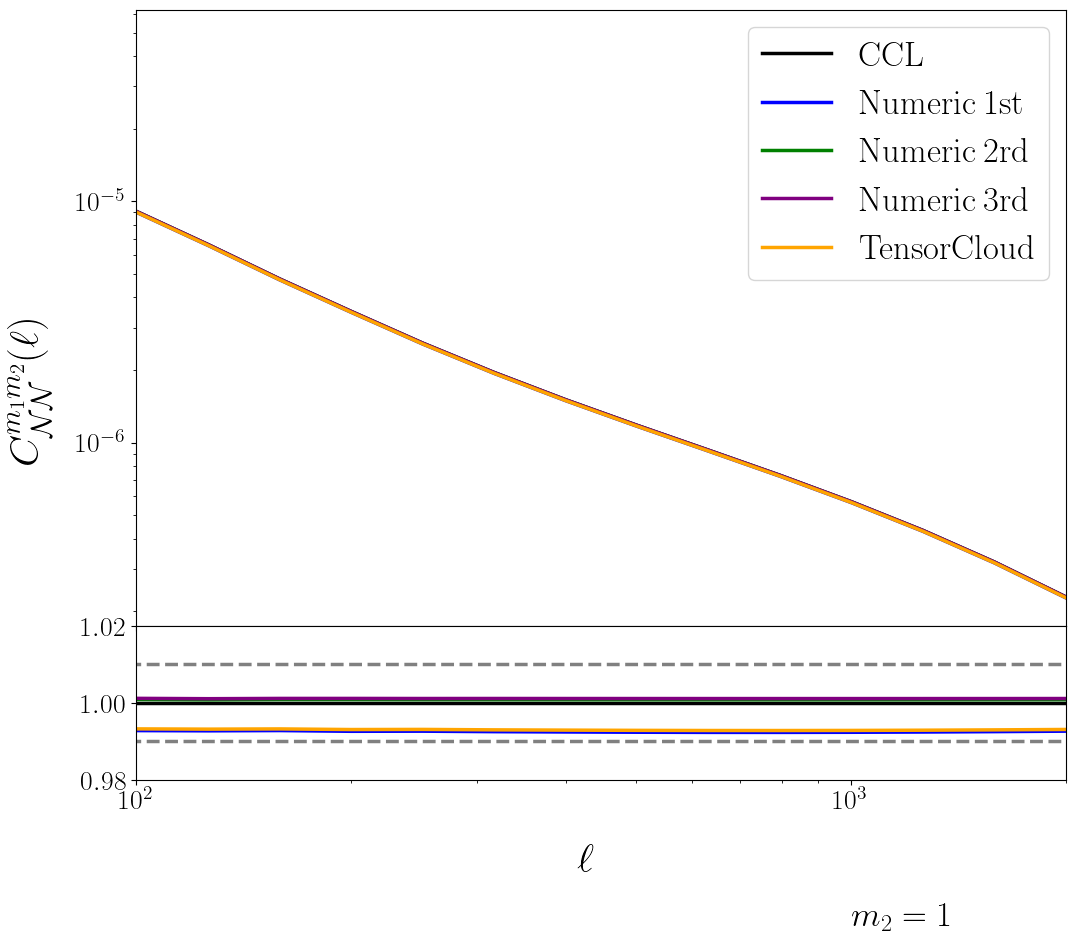

In [9]:
#Plot the results

BIN_INDEX1 = 0
BIN_INDEX2 = 0

pyplot.rcParams['font.size'] = 20
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (12, 10))
GRIDSPEC = GridSpec(10, 12, figure = FIGURE, wspace = 0.0, hspace = 0.0)

PLOT = FIGURE.add_subplot(GRIDSPEC[:8,:12])

PLOT.plot(ell_grid, C_CCL[BIN_INDEX1, BIN_INDEX2,:], color = 'black', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{CCL}$')

PLOT.plot(ell_grid, C_DATA1[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 1st}$')

PLOT.plot(ell_grid, C_DATA2[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 2rd}$')

PLOT.plot(ell_grid, C_DATA3[BIN_INDEX1, BIN_INDEX2,:], color = 'purple', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 3rd}$')

PLOT.plot(ell_grid, C_DATA[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{TensorCloud}$')

PLOT.text(x = 10**3, y = 10**-7, s = r'$m_1= {:.0f}$'.format(BIN_INDEX1 + 1), fontsize = 25)

PLOT.text(x = 10**3, y = 10**-8, s = r'$m_2 = {:.0f}$'.format(BIN_INDEX2 + 1), fontsize = 25)

PLOT.set_yscale('log')
PLOT.set_xscale('log')
PLOT.set_xlim(100, 2000)

PLOT.set_xticklabels([])
PLOT.get_yticklabels()[0].set_visible([])
PLOT.legend(loc = 'upper right', fontsize = 25)

PLOT = FIGURE.add_subplot(GRIDSPEC[8:10,:12])

PLOT.plot(ell_grid, numpy.ones(ell_size + 1), color = 'black', linestyle = '-', linewidth = 2.5)

PLOT.plot(ell_grid, numpy.ones(ell_size + 1) * (1.00 + 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

PLOT.plot(ell_grid, numpy.ones(ell_size + 1) * (1.00 - 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

PLOT.plot(ell_grid, C_RATIO1[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5)

PLOT.plot(ell_grid, C_RATIO2[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5)

PLOT.plot(ell_grid, C_RATIO3[BIN_INDEX1, BIN_INDEX2,:], color = 'purple', linestyle = '-', linewidth = 2.5)

PLOT.plot(ell_grid, C_RATIO[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5)

PLOT.set_xscale('log')
PLOT.set_xlim(100, 2000)
PLOT.set_ylim(0.98, 1.02)
FIGURE.supxlabel(r'$\ell$', fontsize = 30)
FIGURE.supylabel(r'$C^{m_1 m_2}_\mathcal{NN} (\ell)$', fontsize = 30)

FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.savefig('C_ELL_NN.pdf', bbox_inches = 'tight')

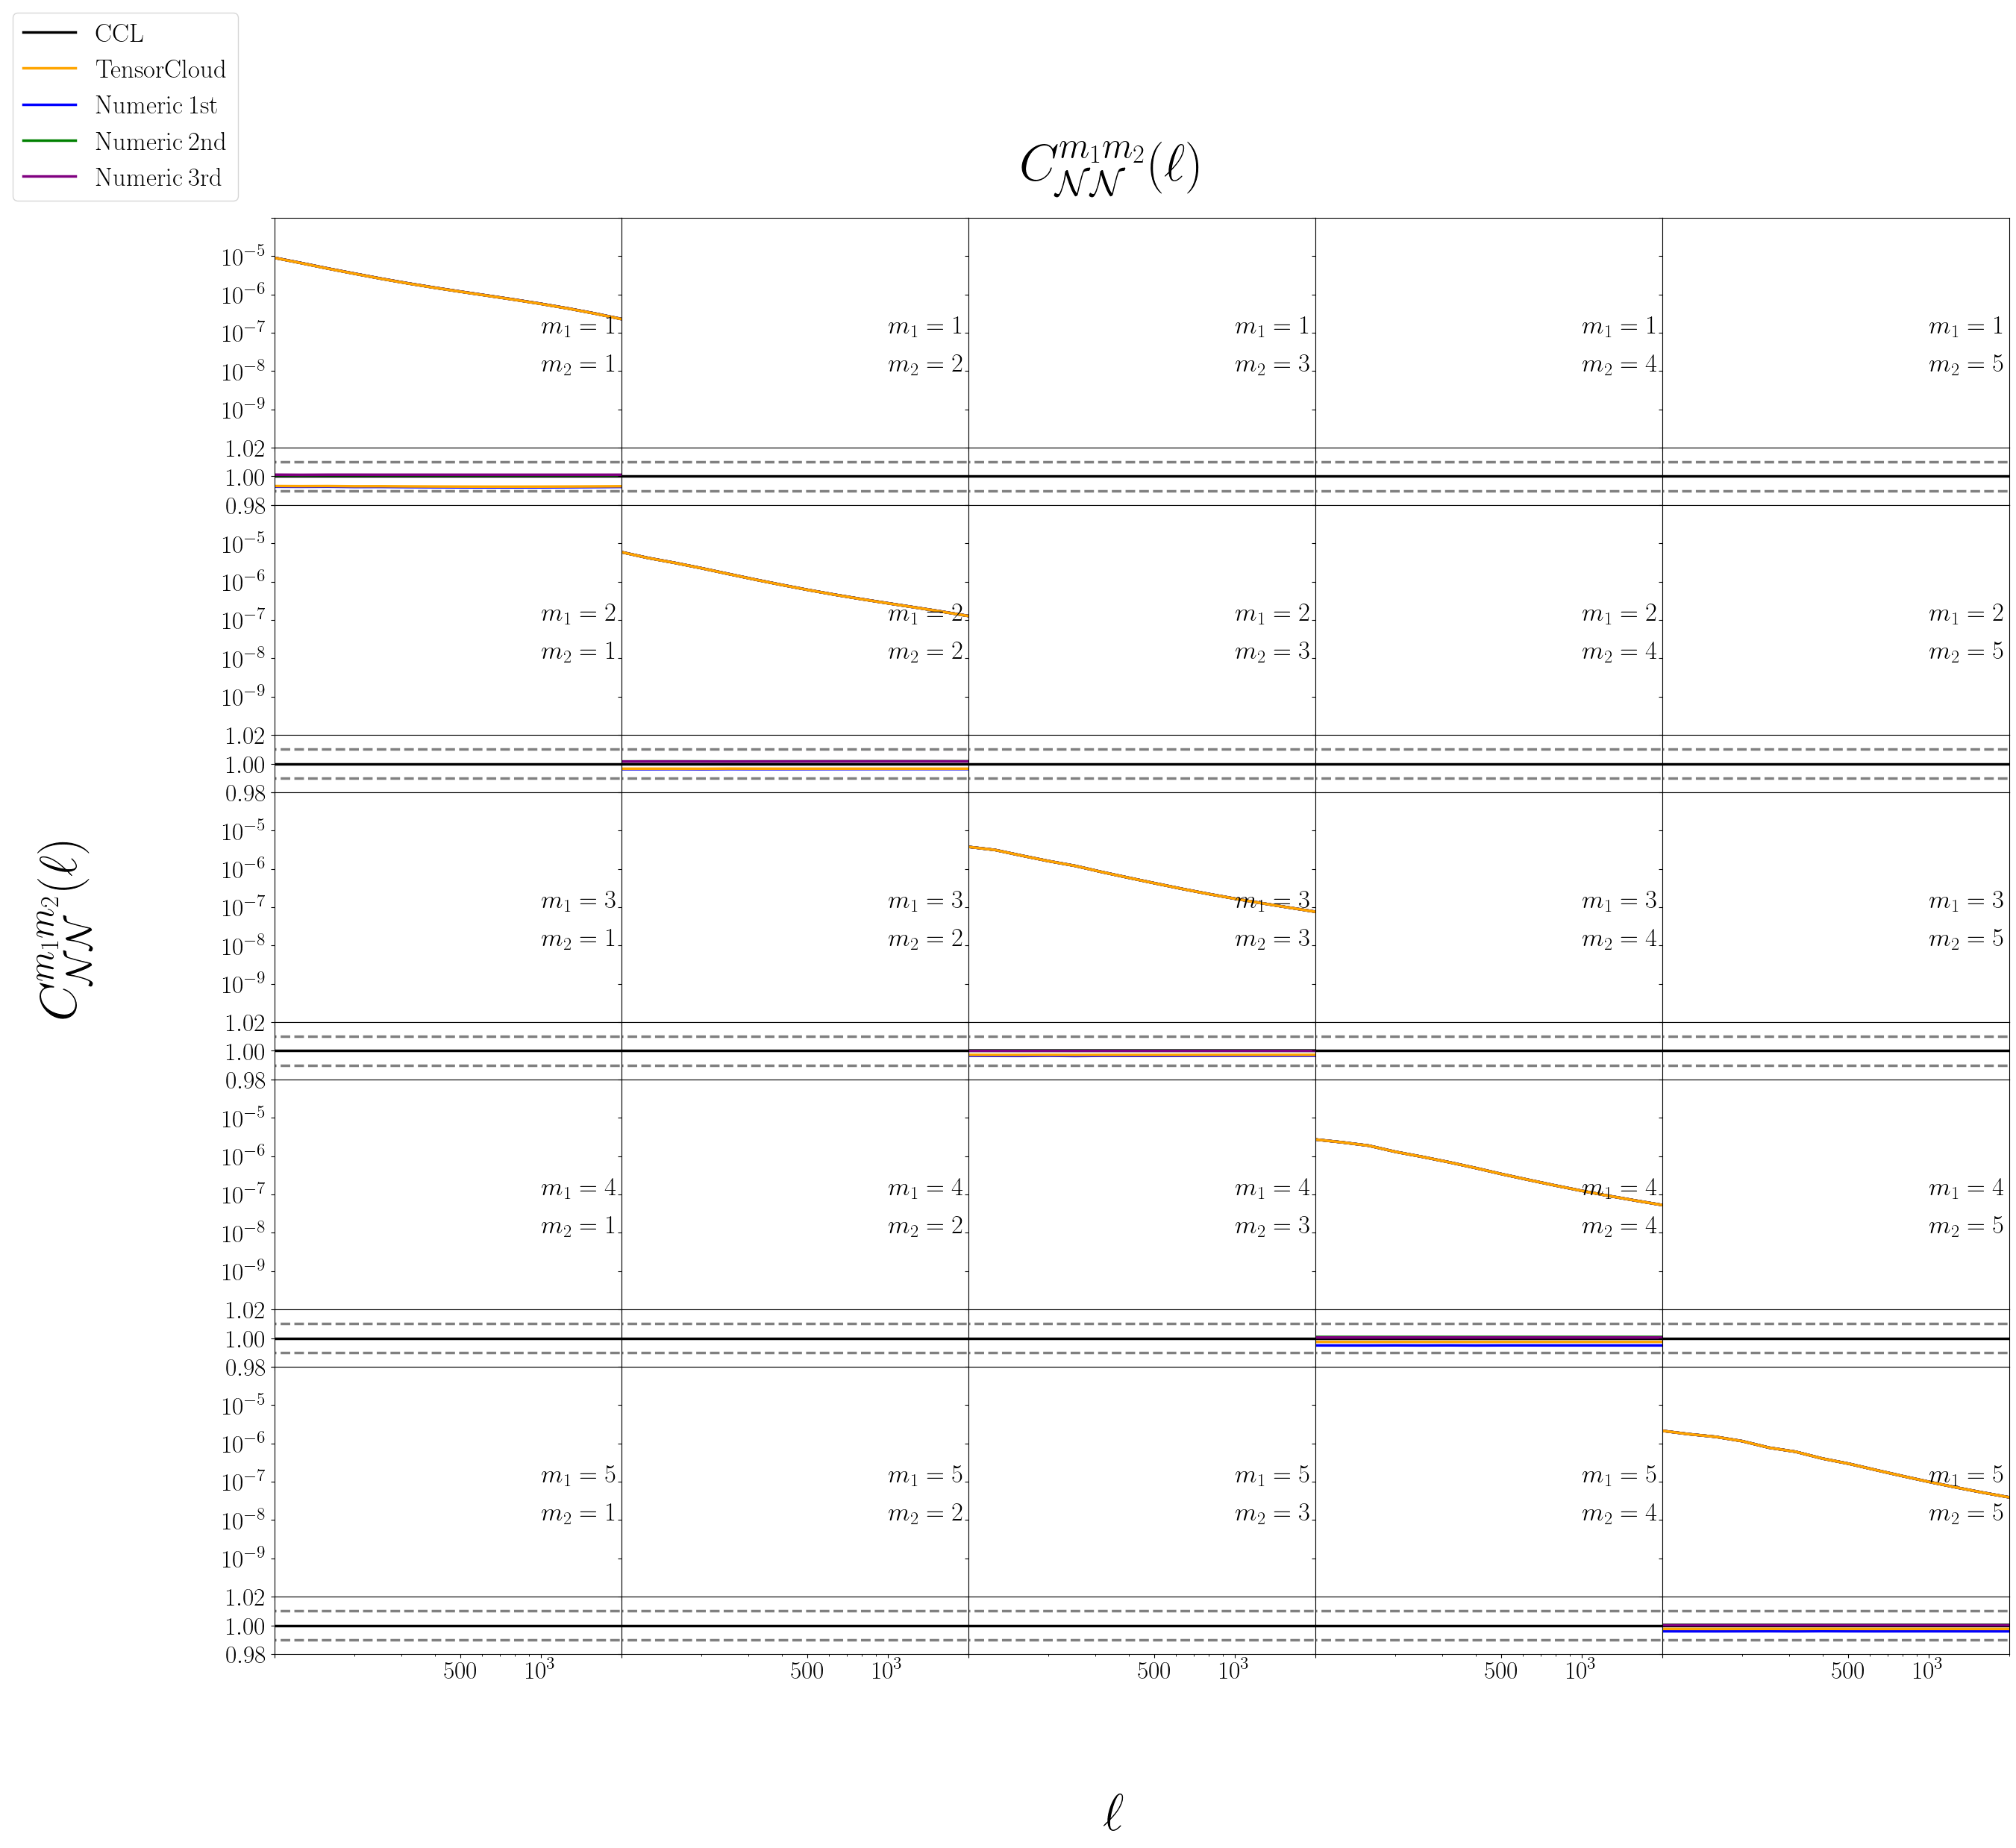

In [15]:
#Compare different bins

pyplot.rcParams['font.size'] = 24
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (bin_lens_size * 6, bin_lens_size * 5))
GRIDSPEC = GridSpec(5 * bin_lens_size, 6 * bin_lens_size, figure = FIGURE, wspace = 0.0, hspace = 0.0)
for (BIN_INDEX1, BIN_INDEX2) in product(range(bin_lens_size), range(bin_lens_size)):
    
    PLOT = FIGURE.add_subplot(GRIDSPEC[5 * BIN_INDEX1: 5 * BIN_INDEX1 + 4, 6 * BIN_INDEX2: 6 * BIN_INDEX2 + 6])

    if BIN_INDEX1 == BIN_INDEX2:

        PLOT.plot(ell_grid, C_CCL[BIN_INDEX1, BIN_INDEX2,:], color = 'black', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{CCL}$')
    
        PLOT.plot(ell_grid, C_DATA1[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 1st}$')
    
        PLOT.plot(ell_grid, C_DATA2[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 2nd}$')
        
        PLOT.plot(ell_grid, C_DATA3[BIN_INDEX1, BIN_INDEX2,:], color = 'purple', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 3rd}$')
    
        PLOT.plot(ell_grid, C_DATA[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{TensorCloud}$')

    PLOT.text(x = 10**3, y = 10**-7, s = r'$m_1= {:.0f}$'.format(BIN_INDEX1 + 1), fontsize = 25)

    PLOT.text(x = 10**3, y = 10**-8, s = r'$m_2 = {:.0f}$'.format(BIN_INDEX2 + 1), fontsize = 25)

    PLOT.set_yscale('log')
    PLOT.set_xscale('log')
    PLOT.set_xlim(100, 2000)

    PLOT.set_ylim(10**-10, 10**-4)
    PLOT.yaxis.set_major_locator(FixedLocator([10**-4,10**-5, 10**-6, 10**-7, 10**-8, 10**-9]))
    PLOT.yaxis.set_major_formatter(FixedFormatter([r'',r'${10}^{-5}$', r'${10}^{-6}$', r'${10}^{-7}$', r'${10}^{-8}$', r'${10}^{-9}$']))
    if BIN_INDEX2 > 0: PLOT.set_yticklabels([])
    
    PLOT.set_xticklabels([])
    PLOT.get_yticklabels()[0].set_visible([])

    PLOT = FIGURE.add_subplot(GRIDSPEC[BIN_INDEX1 * 5 + 4: BIN_INDEX1 * 5 + 5, BIN_INDEX2 * 6: BIN_INDEX2 * 6 + 6])

    PLOT.plot(ell_grid, numpy.ones(ell_size + 1), color = 'black', linestyle = '-', linewidth = 2.5)

    PLOT.plot(ell_grid, numpy.ones(ell_size + 1) * (1.00 + 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

    PLOT.plot(ell_grid, numpy.ones(ell_size + 1) * (1.00 - 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

    if BIN_INDEX1 == BIN_INDEX2:

        PLOT.plot(ell_grid, C_RATIO1[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5)
    
        PLOT.plot(ell_grid, C_RATIO2[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5)
        
        PLOT.plot(ell_grid, C_RATIO3[BIN_INDEX1, BIN_INDEX2,:], color = 'purple', linestyle = '-', linewidth = 2.5)
        
        PLOT.plot(ell_grid, C_RATIO[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5)

    PLOT.set_xscale('log')
    PLOT.set_xlim(100, 2000)
    PLOT.set_ylim(0.98, 1.02)
    PLOT.xaxis.set_major_locator(FixedLocator([100, 500, 1000, 5000]))
    PLOT.xaxis.set_major_formatter(FixedFormatter([r'', r'$500$', r'${10}^3$', r'$5000$']))
    if BIN_INDEX1 < bin_lens_size - 1: PLOT.set_xticklabels([])
    if BIN_INDEX2 > 0: PLOT.set_yticklabels([])
    PLOT.get_xticklabels()[0].set_visible([])
legend_handles = [
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=2.5, label=r'$\mathrm{CCL}$'),
    mlines.Line2D([], [], color='orange', linestyle='-', linewidth=2.5, label=r'$\mathrm{TensorCloud}$'),
    mlines.Line2D([], [], color='blue', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 1st}$'),
    mlines.Line2D([], [], color='green', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 2nd}$'),
    mlines.Line2D([], [], color='purple', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 3rd}$')
]

FIGURE.legend(handles=legend_handles, loc='upper left', fontsize=25)
FIGURE.suptitle(r'$C^{m_1 m_2}_\mathcal{NN} (\ell)$', fontsize=50, y=0.92)
FIGURE.supxlabel(r'$\ell$', fontsize = 50)
FIGURE.supylabel(r'$C^{m_1 m_2}_\mathcal{NN} (\ell)$', fontsize = 50)

FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.savefig('C_M_ELL_NN.pdf', bbox_inches = 'tight')
FIGURE.show()